# Brain Tumor Detection Using a Convolutional Neural Network
## BY Utkarsh Kumar

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

# Data Preparation & Preprocessing

In [2]:
def crop_brain_contour(image, plot=False):
    
    # here we are Converting the image to grayscale, and blurring it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    # here we are Finding contours in thresholded image, then grabbing the largest one
    cnts = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # here we are Finding the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # here we are cropping new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

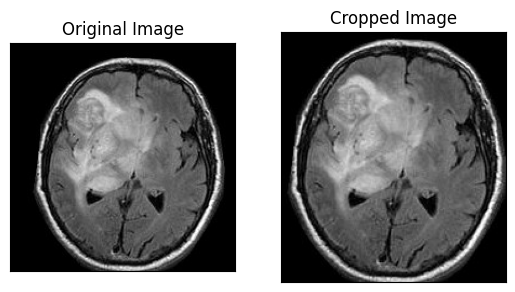

In [3]:
ex_img = cv2.imread('yes/Y2.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Loading data:

In [4]:
def load_data(dir_list, image_size):

    # here we are loading all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # hee we are loading the image
            image = cv2.imread(directory + '\\' + filename)
            # here we are cropping the brain and ignoring the unnecessary part of the image
            image = crop_brain_contour(image, plot=False)
            # here we are resizing the image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


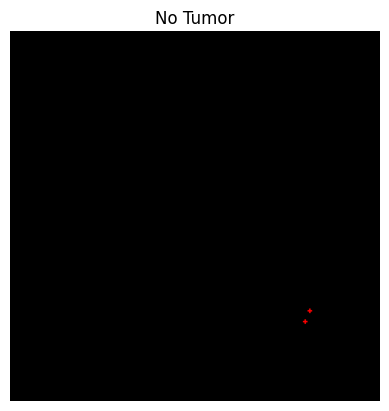

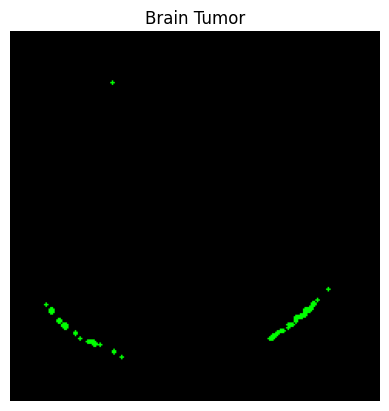

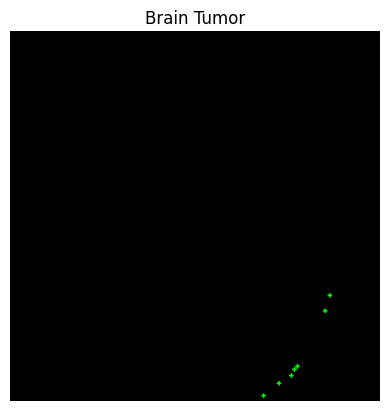

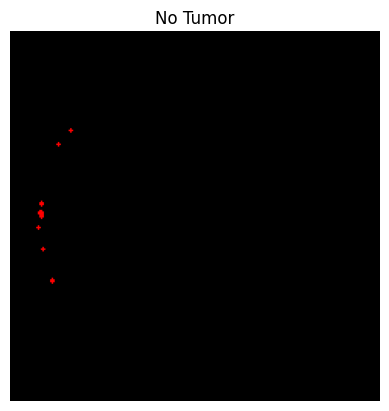

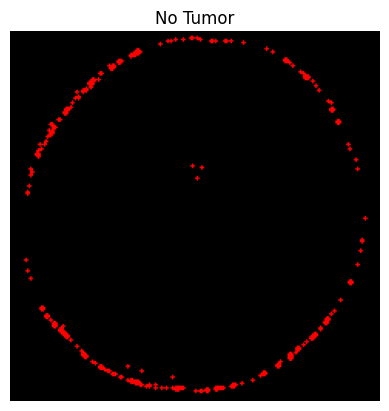

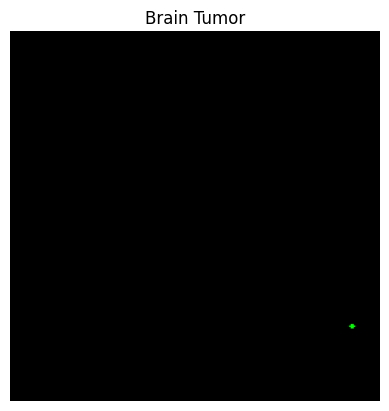

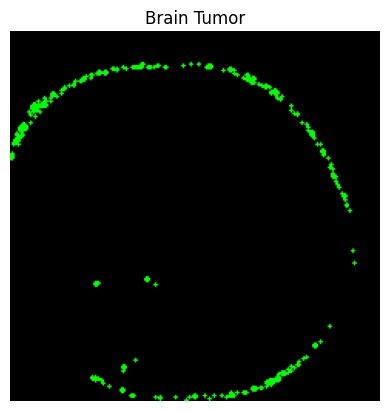

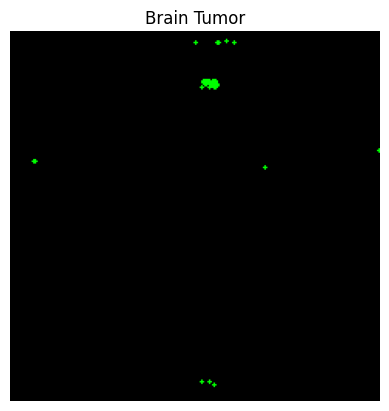

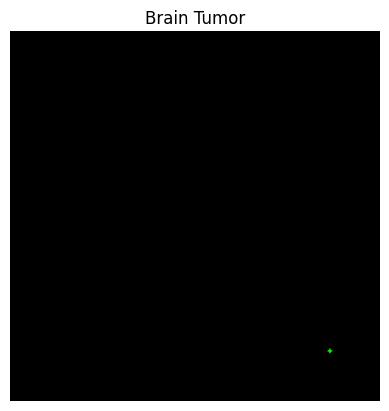

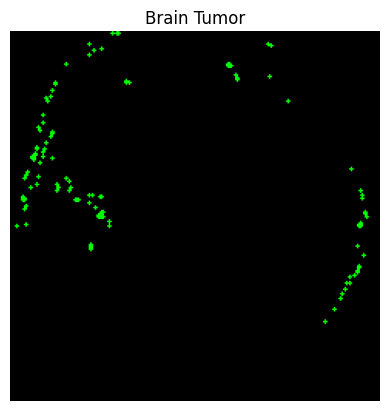

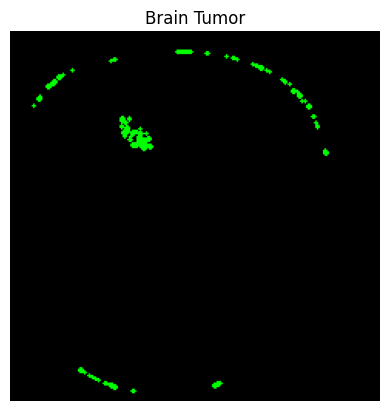

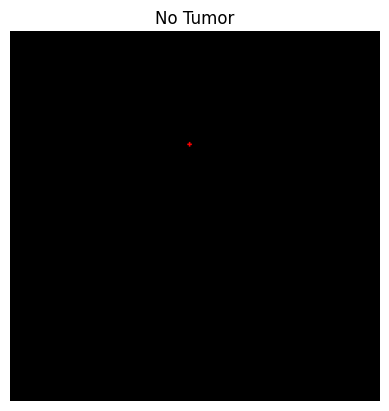

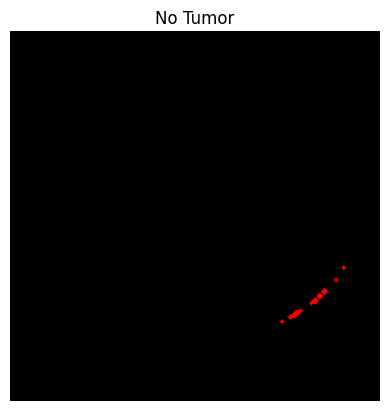

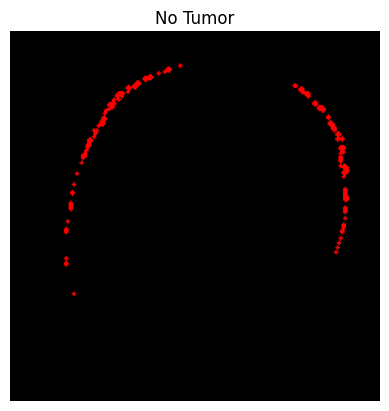

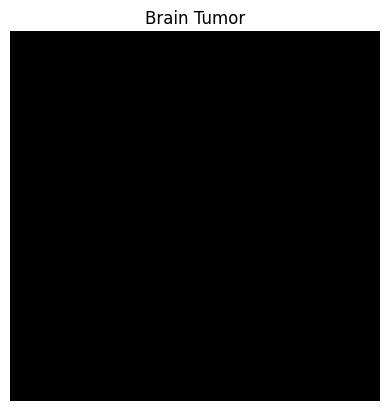

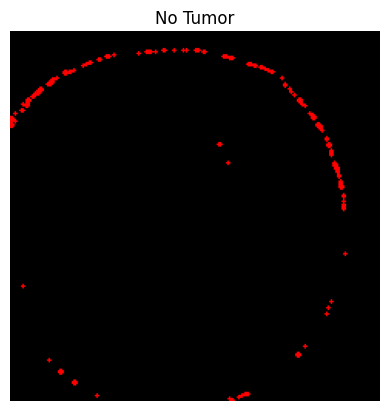

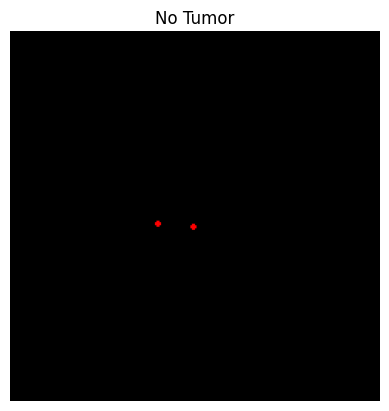

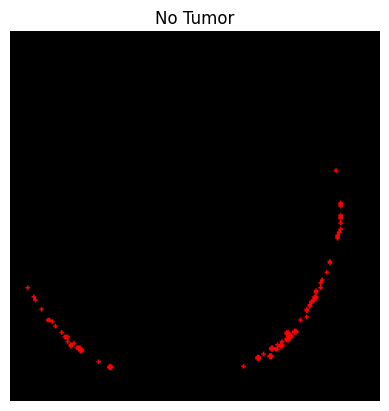

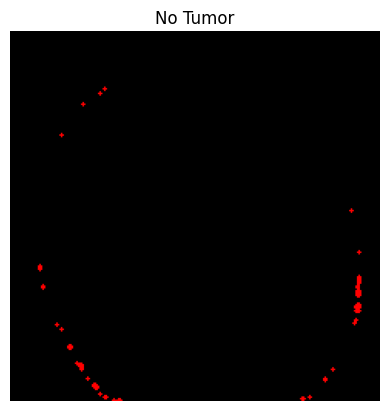

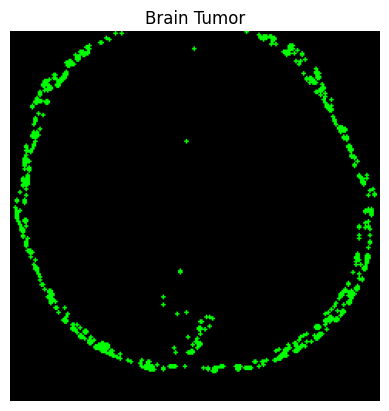

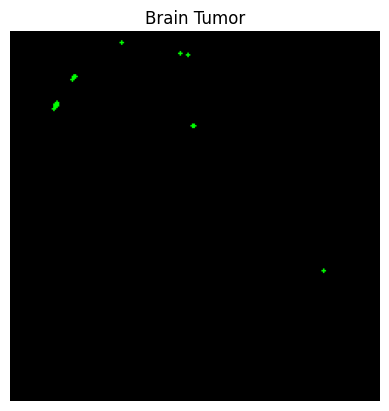

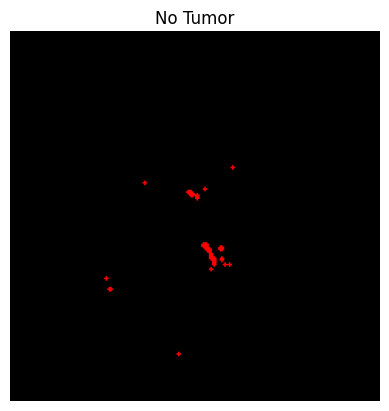

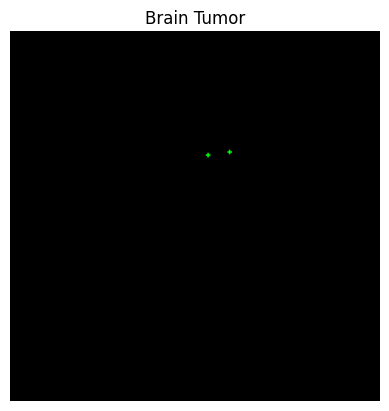

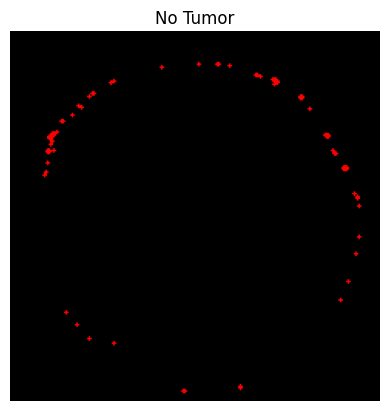

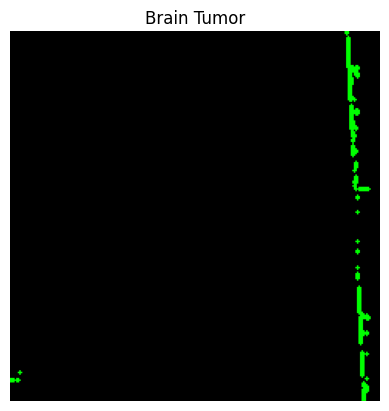

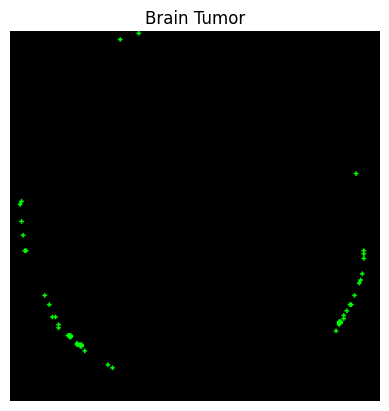

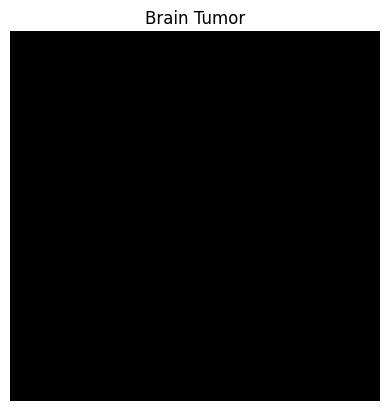

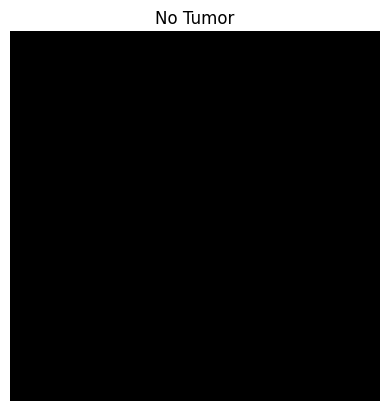

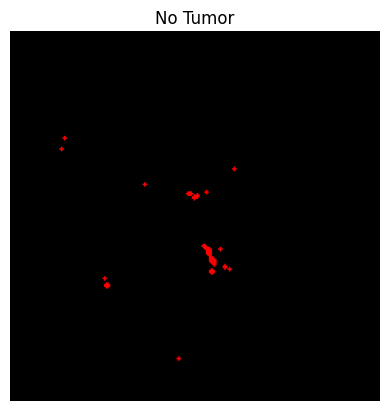

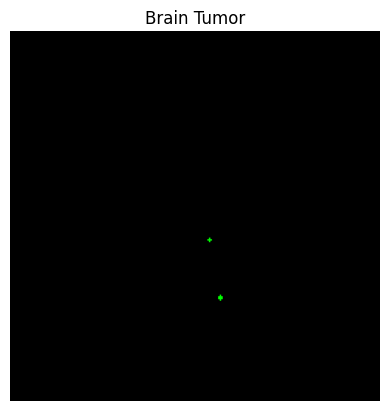

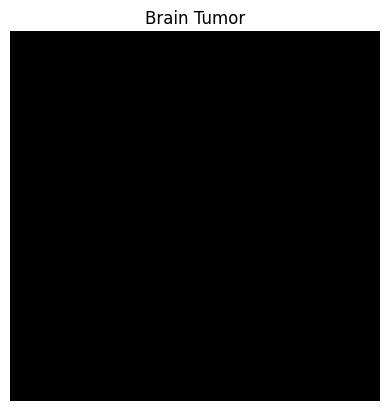

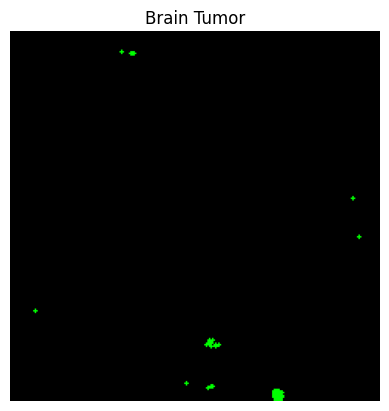

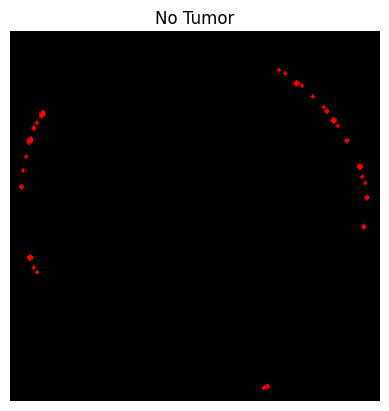

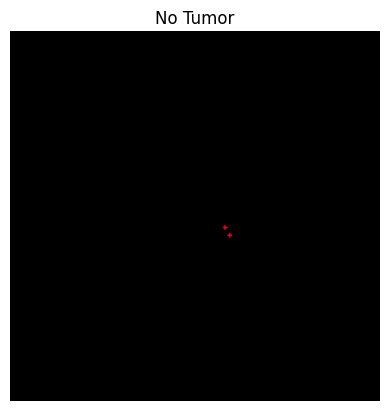

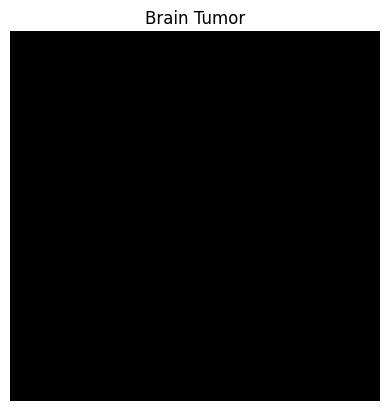

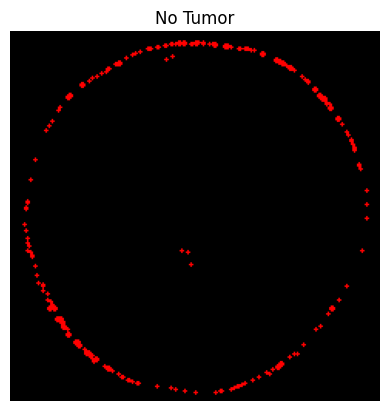

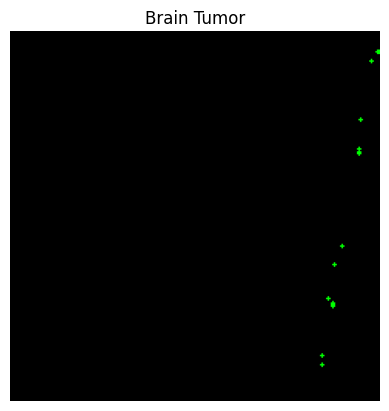

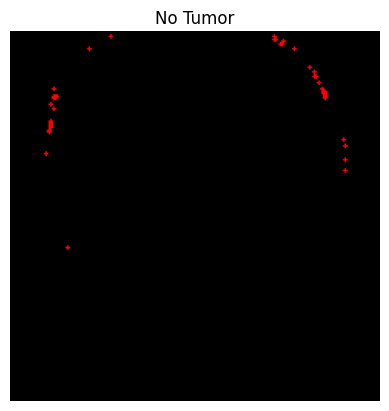

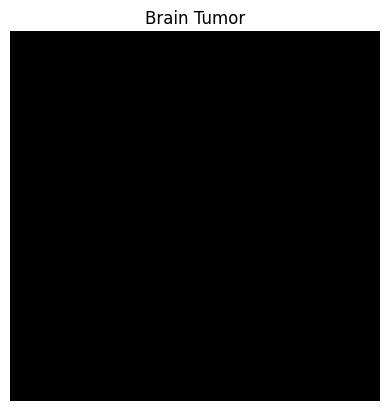

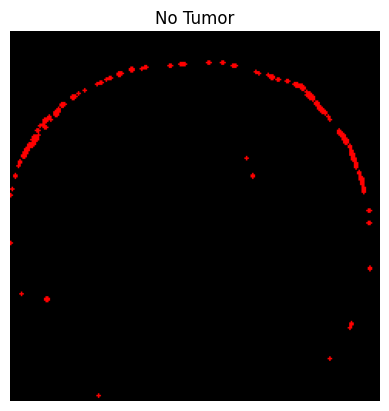

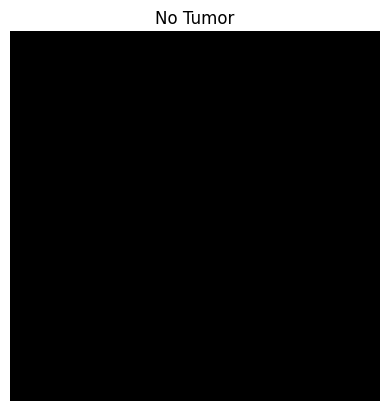

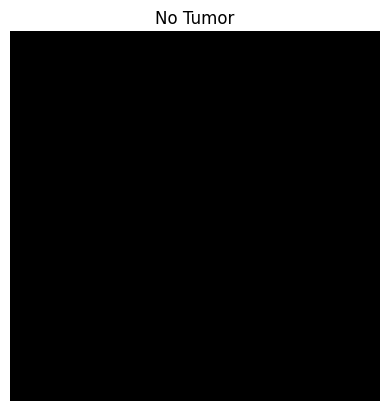

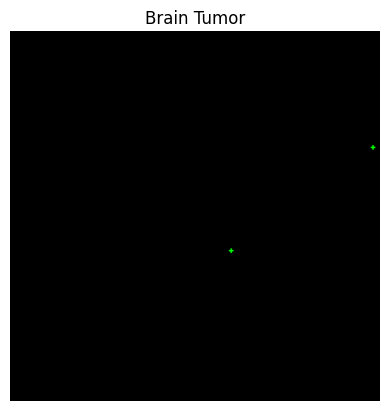

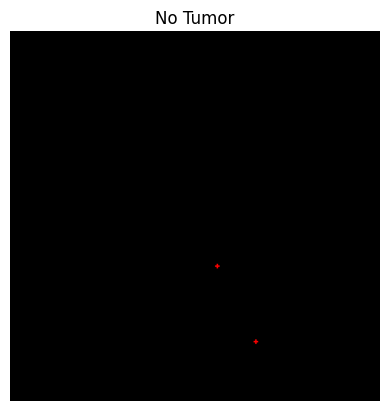

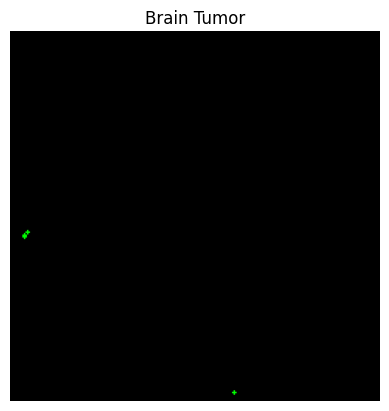

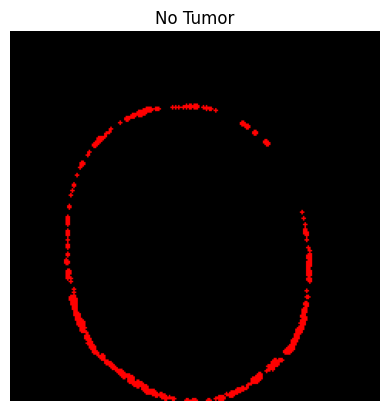

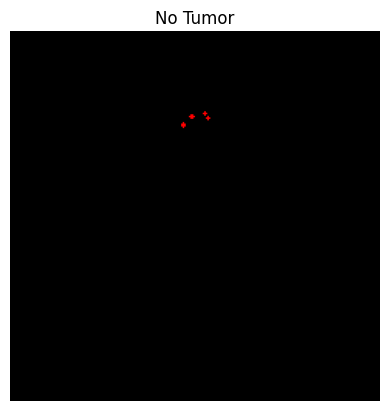

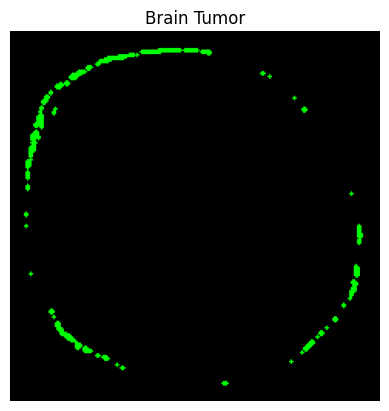

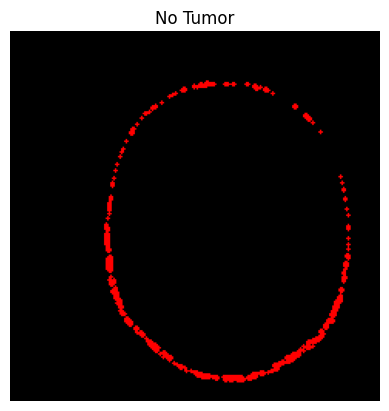

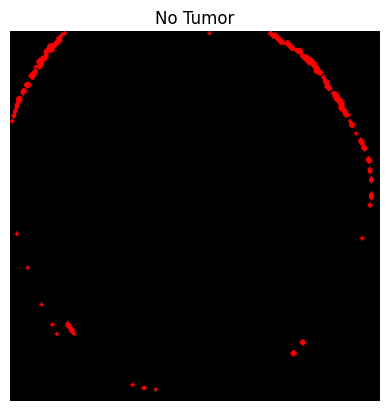

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_contours(X, y):
    for i in range(50):
        # Convert the image to grayscale
        gray = cv2.cvtColor(X[i].astype(dtype=np.uint8), cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw contours on the original image based on label
        if y[i] == 1:
            color = (0, 255, 0)  # Green color for positive class
        else:
            color = (0, 0, 255)  # Red color for negative class
        
        img_contours = cv2.drawContours(X[i].copy(), contours, -1, color, 2)
        
        # Plot the image with contours
        plt.imshow(cv2.cvtColor(img_contours.astype(dtype=np.uint8), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Brain Tumor' if y[i] == 1 else 'No Tumor')
        plt.show()

# Assuming X contains images and y contains their corresponding labels
plot_contours(X, y)




# Plotting sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

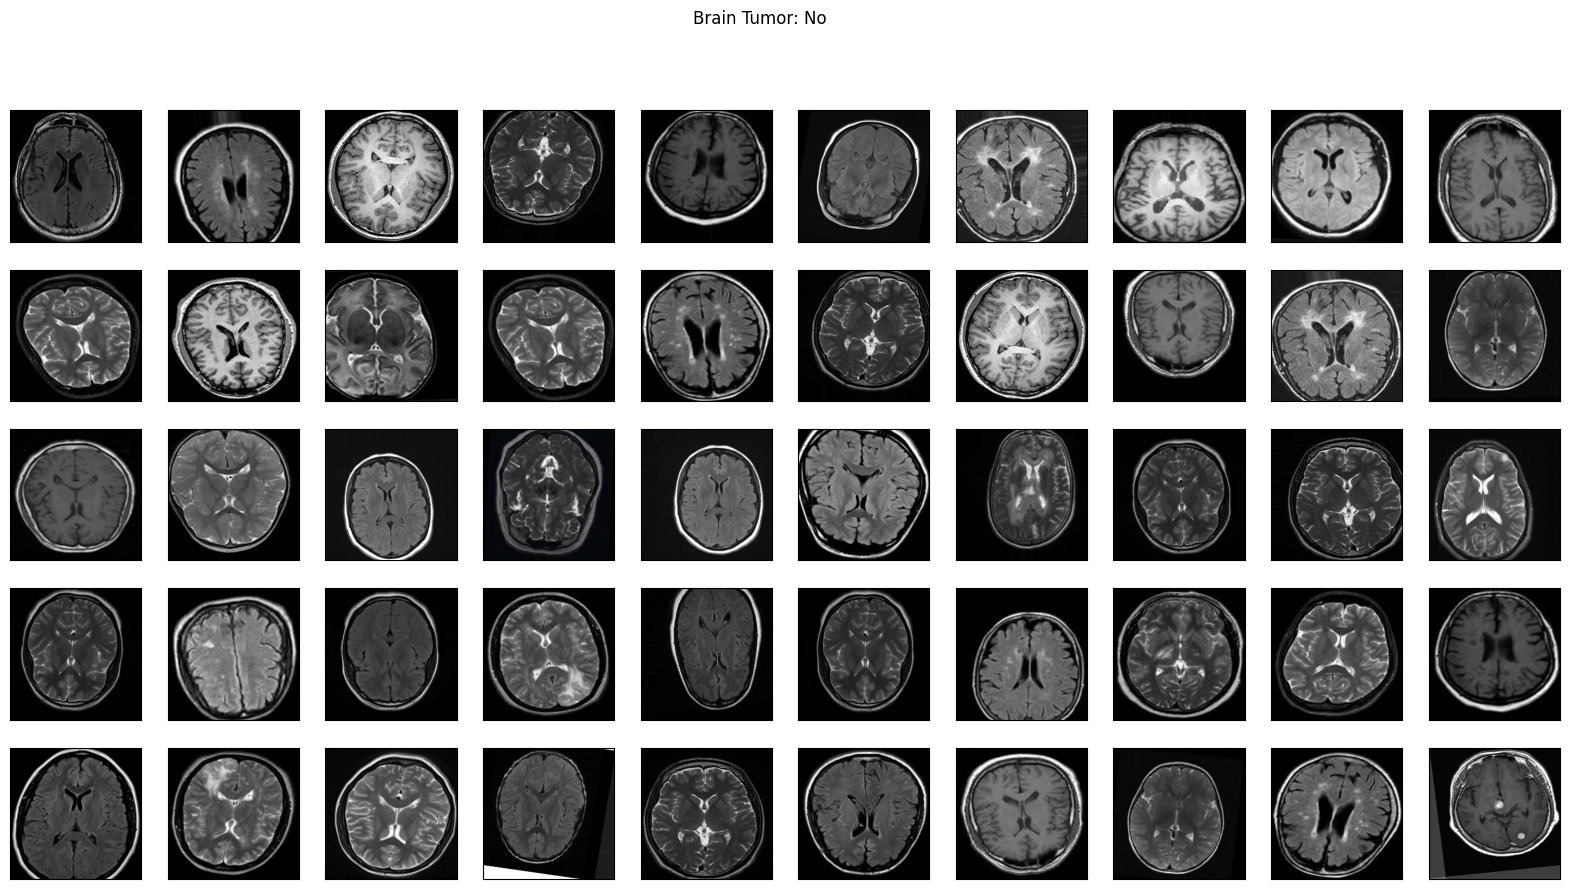

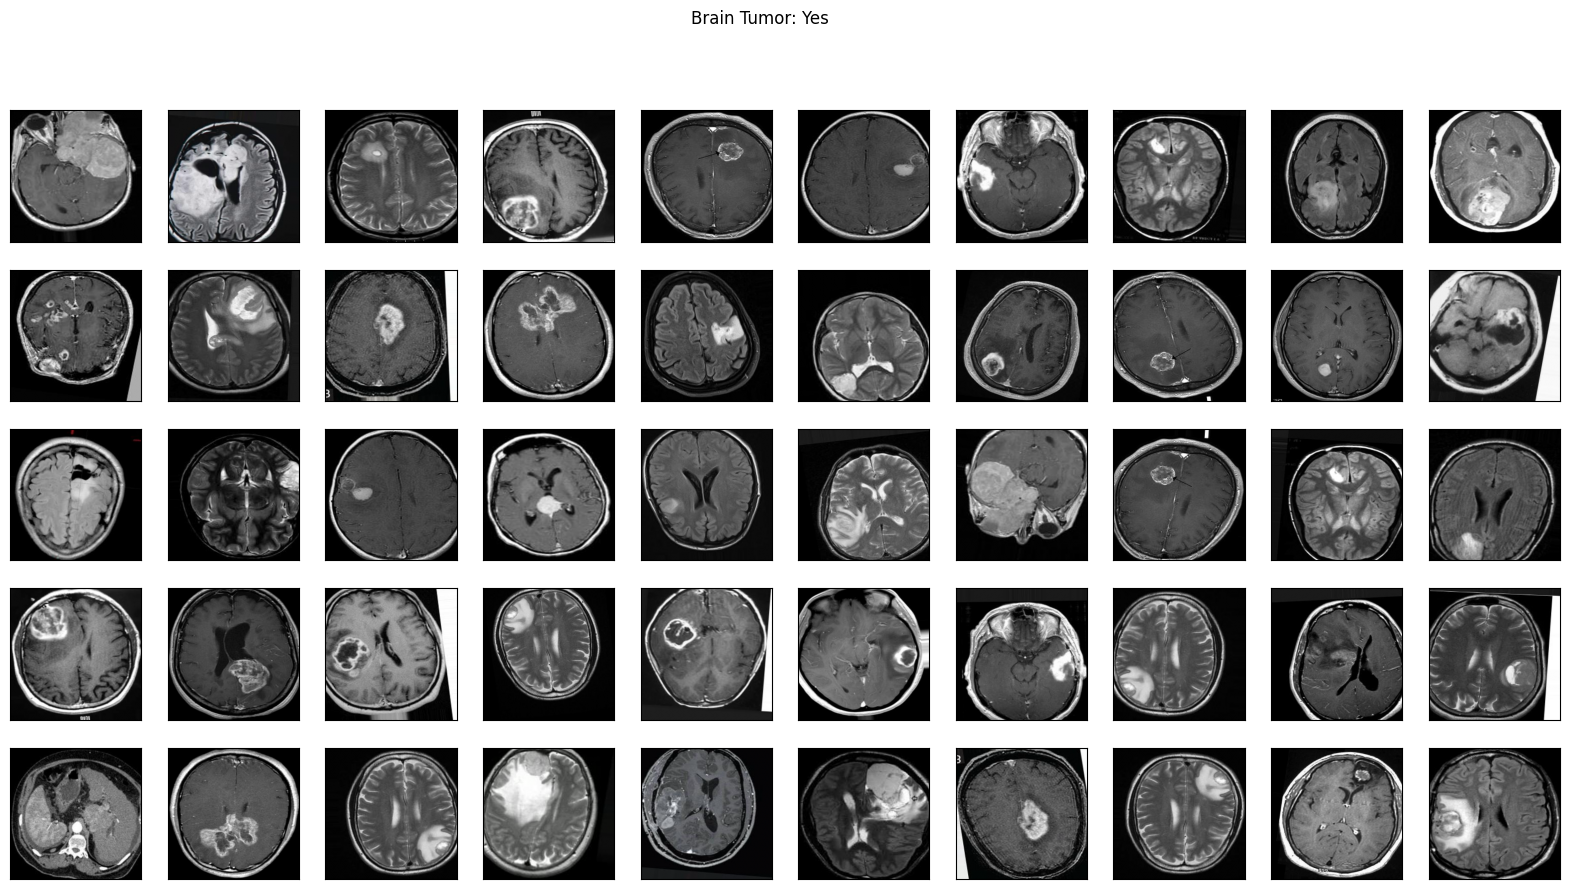

In [8]:
plot_sample_images(X, y)

# Spliting the data:

In [9]:
def split_data(X, y, test_size=0.2):
       
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Building the model

<img src='convnet_architecture.jpg'>

In [14]:
def build_model(input_shape):
    
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model

In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.8960 - loss: 0.2229 - val_accuracy: 0.7000 - val_loss: 0.6479
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.9644 - loss: 0.1408 - val_accuracy: 0.7903 - val_loss: 0.4744
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.9538 - loss: 0.1433 - val_accuracy: 0.7645 - val_loss: 0.7044
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.9006 - loss: 0.2470 - val_accuracy: 0.6903 - val_loss: 0.8165
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.9238 - loss: 0.1844 - val_accuracy: 0.8323 - val_loss: 0.4506
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.8831 - loss: 0.2709 - val_accuracy: 0.8097 - val_loss: 0.5990
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.9388 - loss: 0.1492 - val_accuracy: 0.7935 - val_loss: 0.4638
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.9809 - loss: 0.0964 - val_accu

In [36]:
history = model.history.history

In [37]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


# Plot of Loss & Accuracy

In [38]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

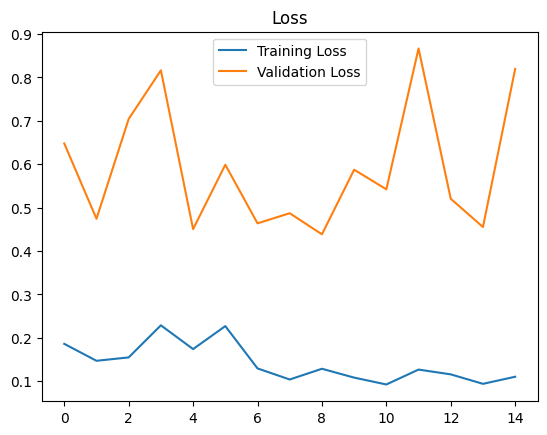

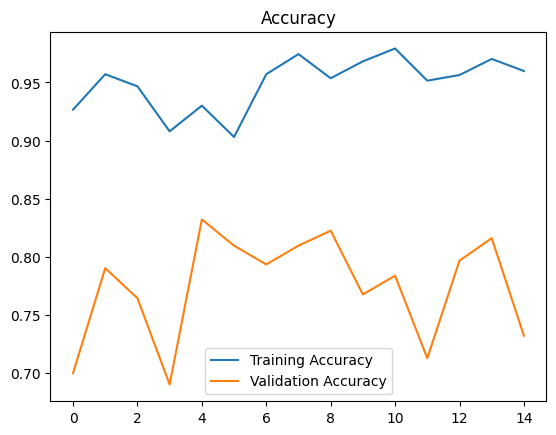

In [39]:
plot_metrics(history) 

# Results

In [40]:
print (f"Test Loss = {history['loss']}")
print (f"Test Accuracy = {history['accuracy']}")

Test Loss = [0.1860833466053009, 0.1470281332731247, 0.15485793352127075, 0.22877444326877594, 0.174004927277565, 0.22698093950748444, 0.129472017288208, 0.10392307490110397, 0.1286599338054657, 0.10826899856328964, 0.09244310855865479, 0.12677830457687378, 0.11573932319879532, 0.09392480552196503, 0.11026333272457123]
Test Accuracy = [0.9266436100006104, 0.9570934176445007, 0.9467127919197083, 0.907958447933197, 0.9301037788391113, 0.9031141996383667, 0.9570934176445007, 0.9743944406509399, 0.953633189201355, 0.9681661128997803, 0.979238748550415, 0.9515570998191833, 0.9564014077186584, 0.9702422022819519, 0.9598615765571594]


In [41]:
y_test_prob =model.predict(X_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [42]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.7211895910780669


In [43]:
y_val_prob =model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [44]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.6844106463878327


In [45]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [46]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [47]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 51.76470588235294%, number of pos examples: 748
Percentage of negative examples: 48.23529411764706%, number of neg examples: 697
Validation Data:
Number of examples: 310
Percentage of positive examples: 54.516129032258064%, number of pos examples: 169
Percentage of negative examples: 45.483870967741936%, number of neg examples: 141
Testing Data:
Number of examples: 310
Percentage of positive examples: 54.193548387096776%, number of pos examples: 168
Percentage of negative examples: 45.806451612903224%, number of neg examples: 142


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


<Figure size 800x600 with 0 Axes>

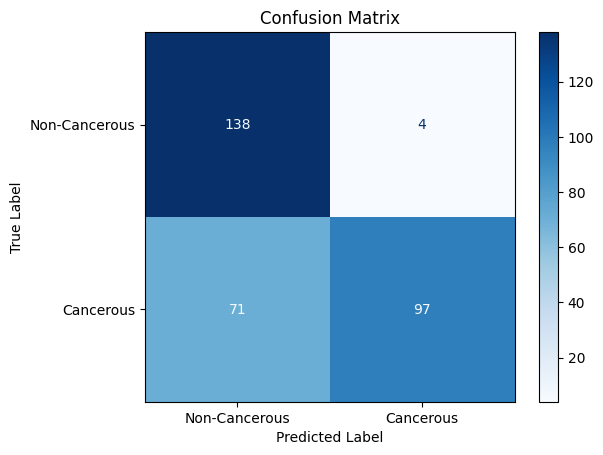

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Used the trained model to predict labels for the test dataset
y_test_pred = model.predict(X_test)
y_test_pred_binary = np.where(y_test_pred > 0.5, 1, 0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

#  Plot the confusion matrix
classes = ['Non-Cancerous', 'Cancerous']
plt.figure(figsize=(8, 6))
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
conf_matrix_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


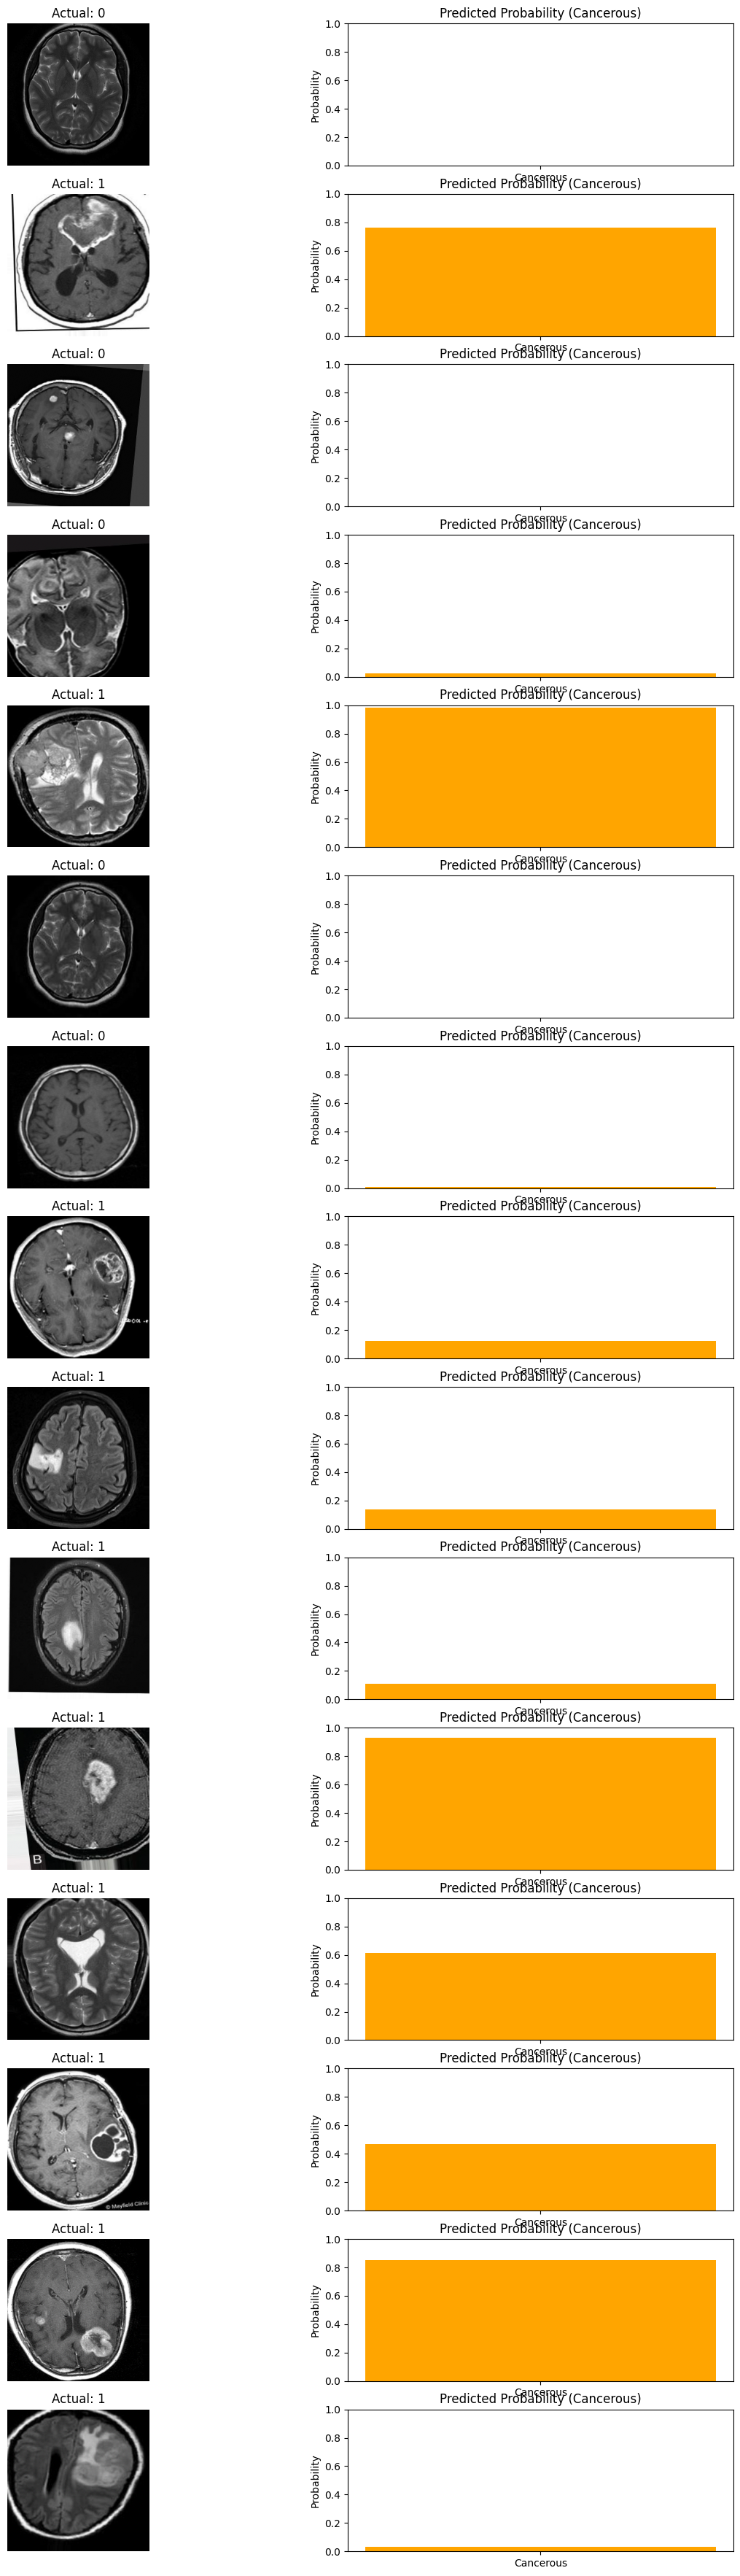

In [49]:
# Display some sample images along with their predicted and actual outputs
def display_samples(X, y_true, y_pred, n_samples=15):
    plt.figure(figsize=(15, 3 * n_samples))
    for i in range(n_samples):
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.imshow(X[i])
        plt.title(f'Actual: {y_true[i][0]}')
        plt.axis('off')

        plt.subplot(n_samples, 2, 2*i + 2)
        plt.bar('Cancerous', y_pred[i][0], color='orange')
        plt.title('Predicted Probability (Cancerous)')
        plt.ylabel('Probability')
        plt.ylim([0, 1])

    plt.show()

# Use the trained model to predict labels for the test dataset
y_test_pred = model.predict(X_test)

# Display some sample images along with their predicted and actual outputs
display_samples(X_test, y_test, y_test_pred, n_samples=15)
